<a href="https://colab.research.google.com/github/Son-Of-Fry/ProyectoIntegrador/blob/main/Avance1_64Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parte 1: Análisis de las conexiónes y EDA

Por José Ricardo Munguía Marín

Esté proyecto a diferencia de otros, trata de unificar ramas distintas de la IA, en especial Visión. Por ello, aún que no se tenga que realizar un EDA exaustivo como en otras ramas, se tiene que considerar una correcta integración de los sistemas, y en está primera parte, vamos a hablar sobre como se están conectando las cámaras y sensores, así como primeras ideas y modelos que utilizarán estos datos.

## 1. Conexiónes necesarias

**Fuentes**

* **RTSP** de la cámara IP (TCP) y **una fuente local** (video0/2).
* **ZMQ** (solo **RGB**; la **profundidad** se excluye en esta etapa por latencia).


### Información previa

Los robots **Unitree** cuentan con varias cámaras integradas o adicionales, desarrolladas por ellos o por terceros. Un caso común son las **Intel RealSense** (RGB-D) para medir profundidades, útiles en desarrollo y detección de objetos.
Sin embargo, una desventaja es que, por su construcción, algunos robots **no incluyen módulos Wi-Fi**; por ello es necesario realizar **retransmisión de video** dependiendo del modelo.


### Cómo funcionan RTSP y ZMQ (resumen rápido)

**RTSP (cámaras IP)**

* Usa H.264/H.265 encapsulado; con OpenCV conviene **FFmpeg**.
* Preferir **TCP** para enlaces inestables: `rtsp_transport=tcp`.
* Evitar lag: `CAP_PROP_BUFFERSIZE = 1`; agregar `stimeout` (tiempo de espera).
* Problemas típicos: credenciales/URL, NAT, jitter y necesidad de **reconexión** tras cortes.

**ZMQ (RGB desde robot/relay)**

* En este proyecto se creó un **contenedor Docker** en una **Raspberry Pi**, con las librerías **RealSense** (necesarias para estas cámaras). La Pi actúa como **relay** y publica frames **RGB** por **PUB/SUB** (ZMQ).
* Consideraciones: **slow-joiner** (el SUB tarda en enganchar), ajustar **cola baja** (`RCVHWM=1`, `CONFLATE=1`) y **reintentos** con *backoff*.

**Cámara especial (GO2 Wheels con módulo térmico)**

* Esta versión incluye un módulo **térmico** con transmisión **cerrada** hacia un control remoto. Al ser una solución propietaria no permite un desarrollo de terceros; sin embargo, el control **incluye salida HDMI**.
* **Solución:** usar una **capturadora de video** (UVC) para ver la pantalla del control; el dispositivo aparece como `/dev/videoX` (p. ej., `/dev/video2`).


fragmento del Dockerfile:


```
# ---------------------------------------------
# Instalar librerías de RealSense
# ---------------------------------------------
RUN mkdir -p /etc/apt/keyrings && \
    curl -sSf https://librealsense.intel.com/Debian/librealsense.pgp \
    | tee /etc/apt/keyrings/librealsense.pgp > /dev/null && \
    echo "deb [signed-by=/etc/apt/keyrings/librealsense.pgp] \
    https://librealsense.intel.com/Debian/apt-repo \
    $(lsb_release -cs) main" \
    | tee /etc/apt/sources.list.d/librealsense.list && \
    apt-get update && apt-get install -y \
    librealsense2-utils librealsense2-dev \
    && rm -rf /var/lib/apt/lists/*
```



Como se mencionaba antes, la desventaja del entorno cerrado ed los robors unitree es que carecen de un módulo wifi, por lo que se tienen que añadir un retransmisor que entre por ethernet al robot, lea los datos de la realsense y la retransmita por wifi.

Provicionalmente, se estará utilzando una raspberry pi 5 para que pueda entrar a este orbot y comunicarse al exterior.

el código de retransmición es el siguiente:



```
import sys
import zmq

IP_G1 = sys.argv[1] if len(sys.argv) > 1

IN_ADDR = f"tcp://{IP_robot_eth}:5555"
OUT_ADDR = "tcp://0.0.0.0:6000"

ctx = zmq.Context()

print(f"🔗 Relay: IN {IN_ADDR} → OUT {OUT_ADDR}")

sub = ctx.socket(zmq.SUB)
sub.connect(IN_ADDR)
sub.setsockopt(zmq.SUBSCRIBE, b"")

pub = ctx.socket(zmq.PUB)
pub.bind(OUT_ADDR)

try:
    while True:
        msg = sub.recv_multipart()
        pub.send_multipart(msg)
except KeyboardInterrupt:
    pass
finally:
    sub.close()
    pub.close()
    ctx.term()

```



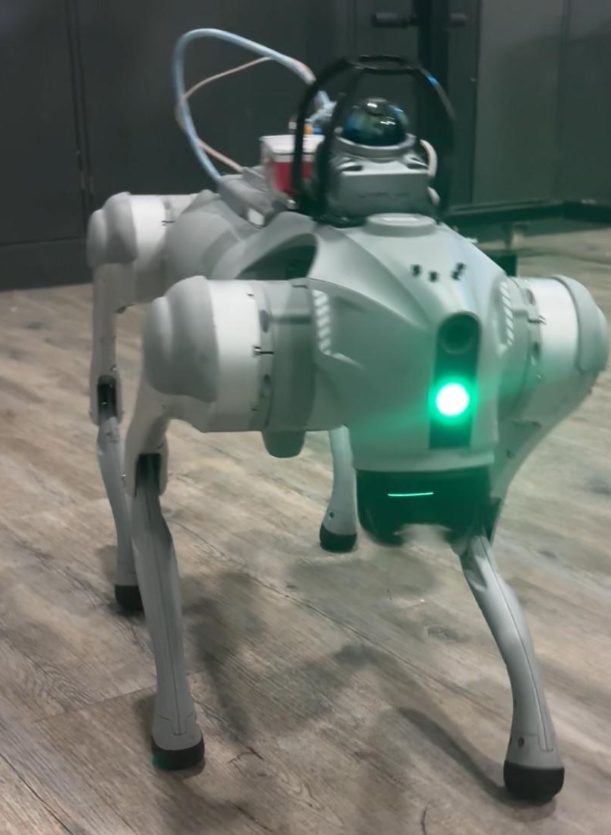

Robot Go2 con retransmisor.

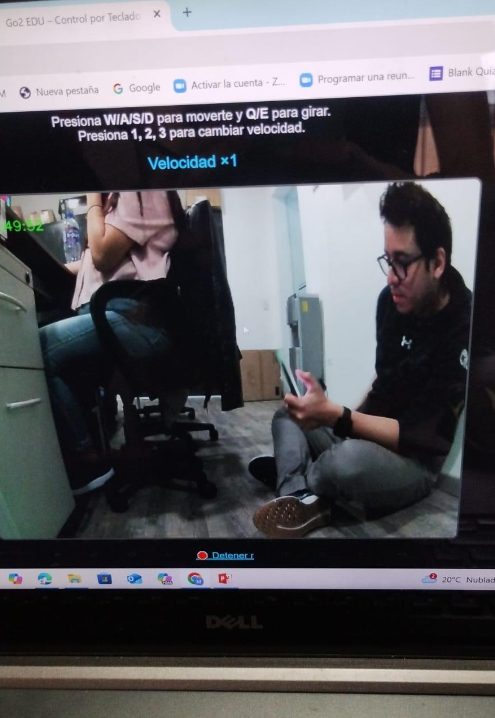

Retransmisor utilizando flask para recibir y mostrar la señal dentro de la misma infraestructura de red wifi.

##4. EDA de “clases” con COCO como punto de partida



In [ ]:
# Instala la API de COCO si no está instalada
!pip install pycocotools -q

In [ ]:
# Importaciones
from pycocotools.coco import COCO
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Descarga anotaciones y una imagen de ejemplo del conjunto Val2017
ANNOTATION_URL = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
IMAGE_URL = 'http://images.cocodataset.org/zips/val2017.zip'

# Crear carpeta y descargar solo si no existe
if not os.path.exists('annotations'):
    !wget {ANNOTATION_URL}
    !unzip -q annotations_trainval2017.zip

if not os.path.exists('val2017'):
    !wget {IMAGE_URL}
    !unzip -q val2017.zip

# Cargar anotaciones
coco = COCO('annotations/instances_val2017.json')



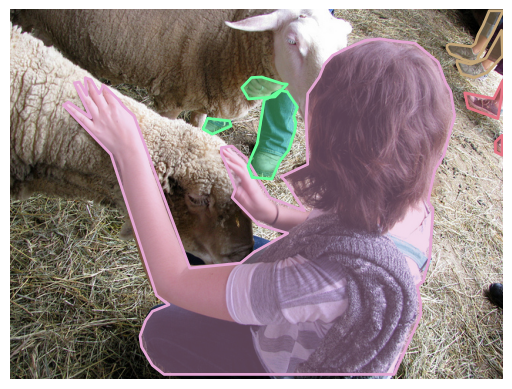

In [ ]:

# Mostrar algunas categorías
cats = coco.loadCats(coco.getCatIds())
cat_names = [cat['name'] for cat in cats]

# Obtener imágenes de una categoría (por ejemplo, "dog")
cat_id = coco.getCatIds(catNms=['person'])
img_ids = coco.getImgIds(catIds=cat_id)
img = coco.loadImgs(img_ids[1])[0]

# Mostrar imagen con anotaciones
img_data = mpimg.imread('val2017/' + img['file_name'])
plt.imshow(img_data)
plt.axis('off')

# Cargar y dibujar anotaciones
ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_id, iscrowd=None)
anns = coco.loadAnns(ann_ids)
coco.showAnns(anns)
plt.show()

In [ ]:
# --- EDA Básico ---
print("\n--- EDA COCO Val2017 ---")
print("Imágenes:", len(coco.getImgIds()))
print("Categorías:", len(coco.getCatIds()))
print("Anotaciones:", len(coco.getAnnIds()))
print('Categorías:', cat_names)  # muestra las categorías



--- EDA COCO Val2017 ---
Imágenes: 5000
Categorías: 80
Anotaciones: 36781
Categorías: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


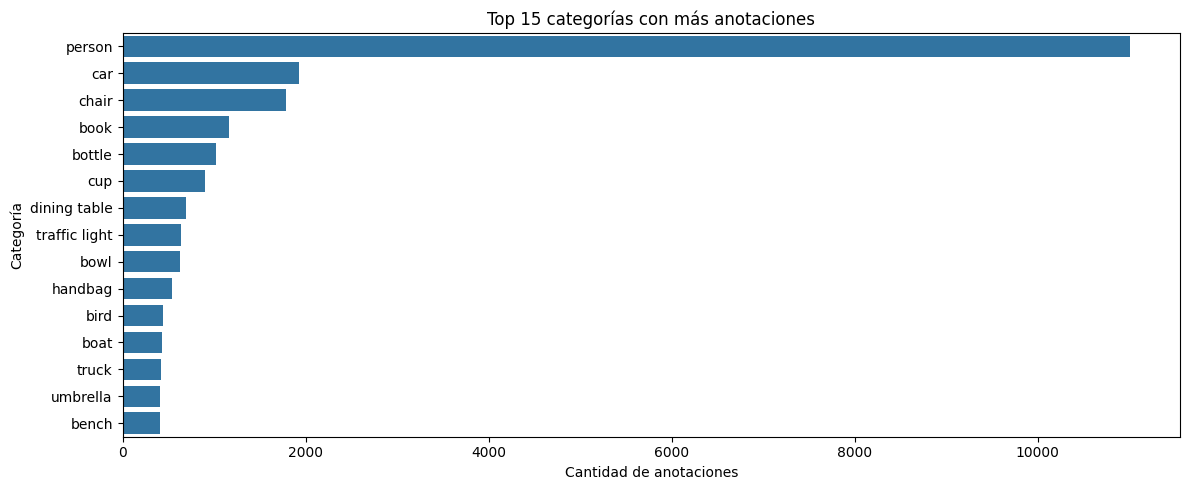

In [ ]:
# Distribución de anotaciones por categoría
cat_ids = coco.getCatIds()
cat_ann_counts = {coco.loadCats([cat_id])[0]['name']: len(coco.getAnnIds(catIds=[cat_id])) for cat_id in cat_ids}
cat_series = pd.Series(cat_ann_counts).sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=cat_series.values[:15], y=cat_series.index[:15])
plt.title('Top 15 categorías con más anotaciones')
plt.xlabel('Cantidad de anotaciones')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()


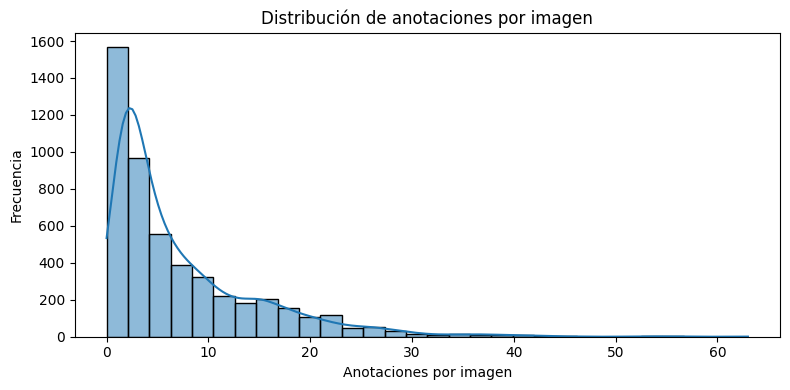

In [ ]:

# Densidad de anotaciones por imagen
img_ann_counts = [len(coco.getAnnIds(imgIds=[img_id])) for img_id in coco.getImgIds()]
plt.figure(figsize=(8,4))
sns.histplot(img_ann_counts, bins=30, kde=True)
plt.title('Distribución de anotaciones por imagen')
plt.xlabel('Anotaciones por imagen')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


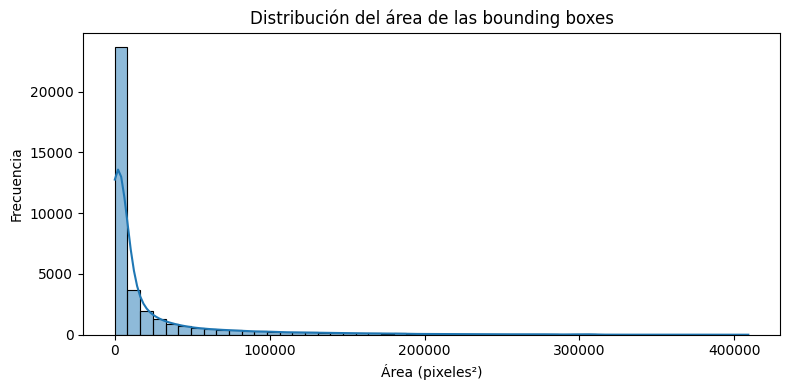

In [ ]:

# Tamaño promedio de bounding boxes
anns = coco.loadAnns(coco.getAnnIds())
bbox_areas = [ann['bbox'][2]*ann['bbox'][3] for ann in anns]
plt.figure(figsize=(8,4))
sns.histplot(bbox_areas, bins=50, kde=True)
plt.title('Distribución del área de las bounding boxes')
plt.xlabel('Área (pixeles²)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## Pasos Futuros:

La base es seguir este conjunto de imágenes junto con un modelo preentrenado como lo es YOLO para añadir nuevos objetos que se deseen integrar, por lo que las principales herramientas a considerar serían:

* **Detección (LabelImg):** solo dibuja cajas delimitadoras (bounding boxes) alrededor de objetos. Se usa para tareas como YOLO, donde solo interesa saber dónde está un objeto y su clase.

* **Segmentación (LabelMe):** dibuja polígonos precisos para contornear la forma real del objeto. Se usa para modelos más avanzados (como Mask R-CNN o segmentación semántica) que necesitan entender la forma exacta.

* **CVAT:** anotación avanzada (cajas, polígonos, tracking), interfaz web, colaboración multiusuario. Requiere Docker y servidor. Gratuito y open source, pero más pesado.

**Unificación en flujo con Qt para extender COCO:**

1. Usamos **LabelImg** (detección) o **LabelMe** (segmentación) para anotar imágenes nuevas localmente con Qt.
2. Exportamos las anotaciones en formato **YOLO** (LabelImg) o **COCO JSON** (LabelMe).
3. Integramos esas anotaciones a un dataset nuevo que replica la estructura de COCO (imágenes + labels + `data.yaml`).

4. Entrenamos **YOLOv5/v8** con este nuevo dataset para detectar objetos nuevos o personas específicas.

Este flujo permite crear una versión extendida del COCO adaptada a las necesidades, totalmente offline, con herramientas open source sin costo que permitirá a los usuarios de los robots, pedirle rastrear nuevas cosas.